# Hottest Topics in Machine Learning
This notebook explores the hottest topics in machine learning using NIPS papers. It includes steps for data preprocessing, exploratory data analysis (EDA), and topic modeling using Latent Dirichlet Allocation (LDA).

## Step 1: Loading the NIPS Papers
We start by loading the dataset containing NIPS papers.

In [6]:
import pandas as pd
import os
import multiprocessing
from wordcloud import WordCloud, STOPWORDS

def load_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return pd.read_csv(file_path)

dataset_path = 'papers.csv'
data = load_data(dataset_path)
data.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


## Step 2: Preparing the Data for Analysis
We will explore the dataset by visualizing the number of papers published per year.

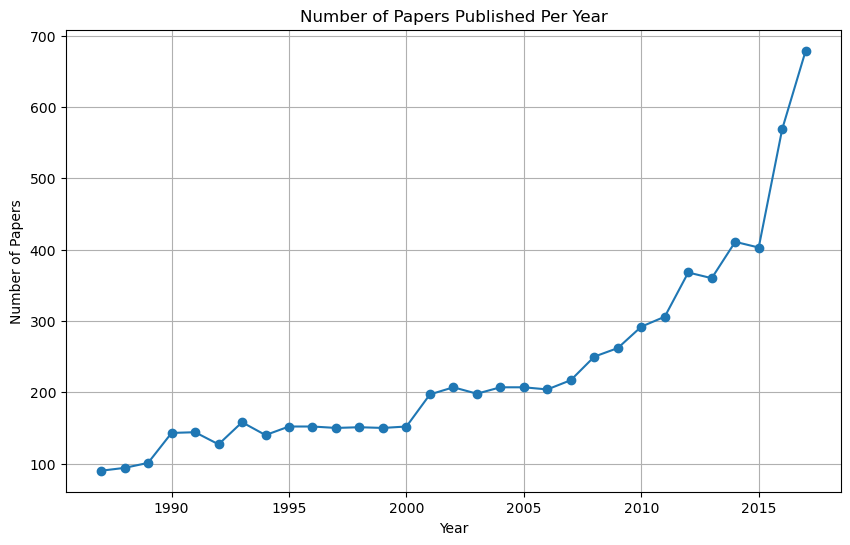

In [7]:
import matplotlib.pyplot as plt

def plot_papers_per_year(data):
    papers_per_year = data['year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    plt.plot(papers_per_year.index, papers_per_year.values, marker='o')
    plt.title('Number of Papers Published Per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.grid(True)
    plt.show()

plot_papers_per_year(data)

## Step 3: Preprocessing the Text Data
We preprocess the text data by removing special characters, numbers, and converting text to lowercase.

In [8]:
import re

PREPROCESS_REGEX = re.compile(r'[^a-zA-Z\s]')

def preprocess_text(text):
    text = PREPROCESS_REGEX.sub('', text).lower()
    return text

data['processed_text'] = data['paper_text'].apply(preprocess_text)
data[['paper_text', 'processed_text']].head()

,paper_text,processed_text
0,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,\n\nselforganization of associative database\n...
1,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,\n\na mean field theory of layer iv of visual ...
2,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,\n\nstoring covariance by the associative\nlon...
3,Bayesian Query Construction for Neural\nNetwor...,bayesian query construction for neural\nnetwor...
4,"Neural Network Ensembles, Cross\nValidation, a...",neural network ensembles cross\nvalidation and...


## Step 4: Generating a Word Cloud with Multiprocessing
We optimize the word cloud generation by using multiprocessing to process text chunks in parallel.

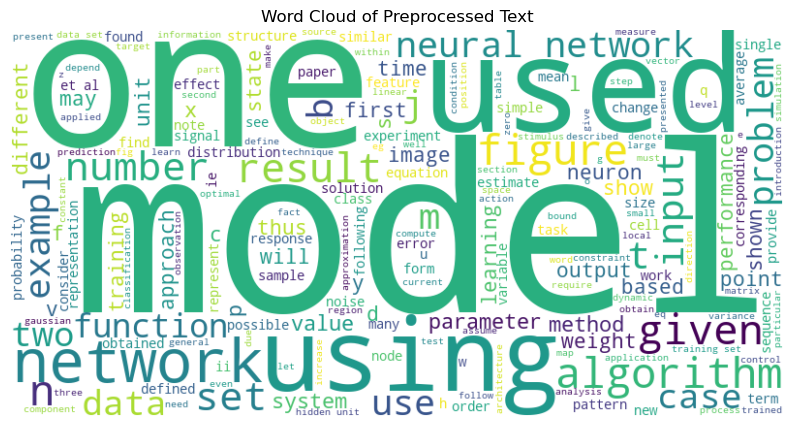

In [9]:


def generate_word_cloud(text_data):
    # Limit the text data to a sample to speed up word cloud generation
    with multiprocessing.Pool() as pool:
        sample_text = ' '.join(pool.map(str, text_data[:1000]))  # Use only the first 1000 entries
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS,).generate(sample_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Preprocessed Text')
    plt.show()

generate_word_cloud(data['processed_text'])

## Step 5: Optimized Topic Modeling with LDA
We optimize the LDA implementation by using a more efficient vectorizer and tuning the LDA parameters for faster computation.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_topic_modeling(documents, n_topics=5, n_top_words=10):
    # Use TfidfVectorizer for better efficiency
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    doc_term_matrix = vectorizer.fit_transform(documents)

    # Optimize LDA with fewer iterations and batch learning
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='batch', random_state=42)
    lda.fit(doc_term_matrix)

    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f'Topic {topic_idx + 1}'] = top_features

    return topics

topics = perform_topic_modeling(data['processed_text'], n_topics=5, n_top_words=10)
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: network, model, learning, image, neural, neurons, networks, training, input, state
Topic 2: episode, episodes, imitation, shortterm, controllers, pomdp, pomdps, stateaction, modulation, depression
Topic 3: player, game, players, games, equilibrium, nash, payoff, revenue, equilibria, price
Topic 4: grammars, clause, episode, episodes, imitation, shortterm, grammar, controllers, pomdp, pomdps
Topic 5: algorithm, data, learning, matrix, model, set, function, kernel, problem, distribution


## Step 6: Plot Most Common Words in the Dataset 

To visualize the most common words in the dataset, we use the `plot_most_common_words` function. This function processes the `processed_text` column, counts word frequencies (excluding stopwords and single letters), and plots the top 20 most frequent words as a bar chart.

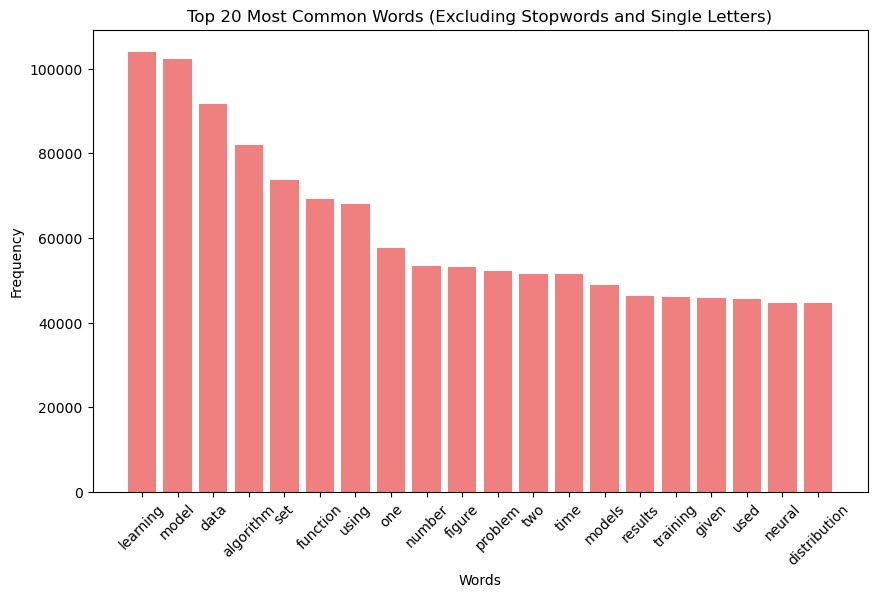

In [15]:

from collections import Counter
def plot_most_common_words(data, n=20):
    all_text = ' '.join(data['processed_text'])
    word_counts = Counter(word for word in all_text.split() if word not in STOPWORDS and len(word) > 1)
    most_common_words = word_counts.most_common(n)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='lightcoral')
    plt.title(f'Top {n} Most Common Words (Excluding Stopwords and Single Letters)')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_most_common_words(data, n=20)

In [16]:
def analyze_future_trends(data):
    recent_year = data['year'].max()
    recent_papers = data[data['year'] >= recent_year - 5]
    topics = perform_topic_modeling(recent_papers['processed_text'], n_topics=5, n_top_words=10)
    print("Future Trends in Machine Learning:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

analyze_future_trends(data)

Future Trends in Machine Learning:
Topic 1: observability, buyers, seller, sghmc, auction, buyer, rezende, ais, bidder, auctions
Topic 2: algorithm, data, learning, matrix, model, function, set, problem, theorem, log
Topic 3: coreset, coresets, wikipedia, streams, segments, segment, summarization, sensitivity, sites, english
Topic 4: observability, buyers, seller, sghmc, auction, buyer, rezende, ais, bidder, auctions
Topic 5: model, network, image, policy, deep, training, learning, layer, networks, neural
